In [4]:
#Create Access to my code
import sys
sys.path.insert(1, '../vidr/')

#Import hte vaedr functions we have created
from vidr import VIDR
from PCAEval import PCAEval
from utils import *

#Import important modules
import scanpy as sc
import scgen as scg
import pandas as pd
import numpy as np
import torch
import seaborn as sns
from scipy import stats
from scipy import linalg
from scipy import spatial
from anndata import AnnData
from scipy import sparse
from statannotations.Annotator import Annotator
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

sc.set_figure_params(dpi = 150, frameon = True)
sns.set_style("dark")
sc.settings.figdir = "../figures"

In [6]:
adata = sc.read_h5ad("../data/srivatsan2020.h5ad")

In [7]:
adata.obs["drug_dose"] = [f"{i}_{j}" for (i, j) in zip(adata.obs["product_name"], adata.obs["dose"])]

In [8]:
adata = setup_anndata(adata, copy = True, batch_key ="drug_dose", labels_key="cell_type")

INFO     Using batches from adata.obs["drug_dose"]                                           
INFO     Using labels from adata.obs["cell_type"]                                            
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 680685 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


In [8]:
# drug_list = adata[~(adata.obs["product_name"] == "Vehicle")].obs["product_name"].unique()

In [9]:
# np.savetxt("../../data/sciplex3_drug_list.txt", drug_list, delimiter=" ", fmt="%s")

In [10]:
# np.random.seed(42)

In [11]:
# ind = np.random.choice(len(drug_list), int(len(drug_list)/5))

In [12]:
# test_drug_list = drug_list[ind]

In [13]:
# np.savetxt("../../data/sciplex3_test_drug_list.txt", test_drug_list, delimiter=" ", fmt="%s")

In [9]:
test_drugs = np.loadtxt("../data/srivatsan2020_testDrugList.txt", dtype = str, delimiter="\t")

In [10]:
test_drugs.shape

(37,)

In [11]:
train_adata = adata[~((adata.obs["product_name"].isin(test_drugs)) & (adata.obs["cell_type"] == "A549"))]

In [12]:
model = VIDR(train_adata.copy(), linear_decoder = False)

None


In [18]:
# model.train(
# max_epochs=100,
# batch_size=256,
# early_stopping=True,
# early_stopping_patience=25,
# train_size=0.8
# )

In [19]:
# model.save(f"../../data/models/Continuous_VAE_sciplex3_80perDrug_24hours_DelA549.pt")

In [13]:
model =  model.load("../data/VAE_Cont_Prediction_sciplex3_80perDrug_24hours_Dela549.pt/", train_adata)

Trying to set attribute `.uns` of view, copying.


INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


In [14]:
latent_X = model.get_latent_representation(adata)
latent_adata = sc.AnnData(X = latent_X, obs = adata.obs.copy())

In [15]:
sc.pp.neighbors(latent_adata)
sc.tl.umap(latent_adata)

         Falling back to preprocessing with `sc.pp.pca` and default params.


In [16]:
latent_adata.obs["Training Split"] = ["Test" if ((i == "A549") & (j in test_drugs)) else "Train" for (i, j) in zip(latent_adata.obs["cell_type"], latent_adata.obs["product_name"])]

In [17]:
latent_adata.obs["Cell Type"] = latent_adata.obs["cell_type"]

In [18]:
latent_adata.obs["cell_dose"] = [f"{j}_{str(i)}" for (i,j) in zip(latent_adata.obs["dose"], latent_adata.obs["cell_type"])]

In [19]:
centroids = {cell:np.average(latent_adata.obsm["X_umap"][latent_adata.obs["cell_dose"] == cell], axis = 0) for cell in np.unique(latent_adata.obs["cell_dose"])}
centroids["0"] = np.average(latent_adata.obsm["X_umap"][latent_adata.obs["dose"] == "0.0"], axis = 0)
centroids["30"] = np.average(latent_adata.obsm["X_umap"][latent_adata.obs["dose"] == "30.0"], axis = 0)

## Supplemental Figure 4A

... storing 'drug_dose' as categorical
... storing 'Training Split' as categorical
... storing 'cell_dose' as categorical


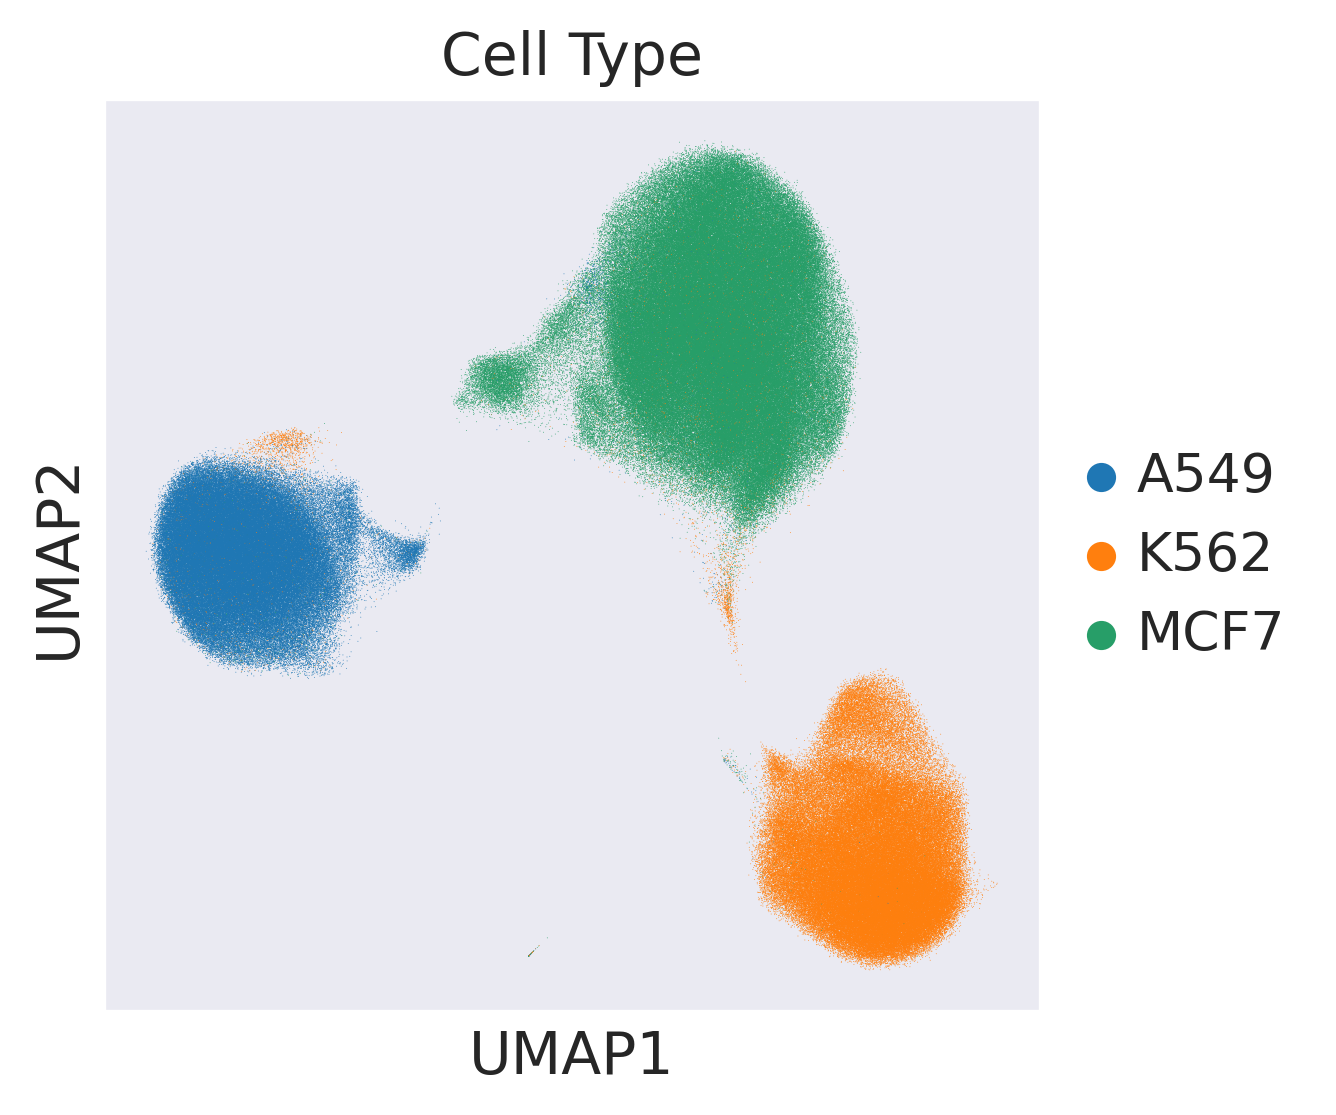

In [20]:
ax = sc.pl.umap(latent_adata, color = ["Cell Type"], frameon=True, return_fig=True)
plt.savefig("../figures/S4A1.svg", bbox_inches='tight')

Trying to set attribute `.uns` of view, copying.


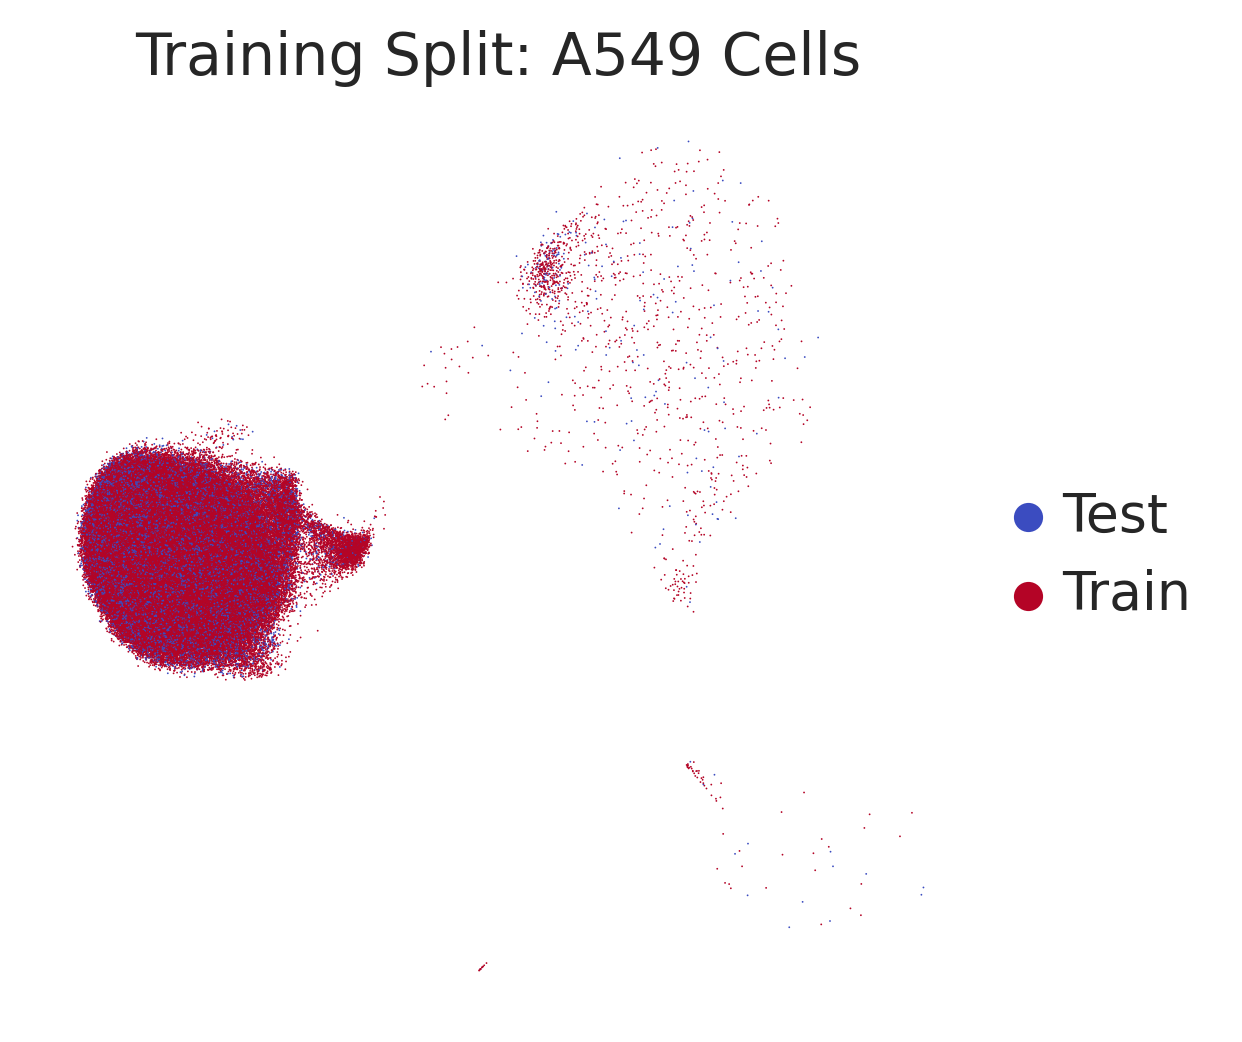

In [21]:
ax =sc.pl.umap(latent_adata[latent_adata.obs["cell_type"] == "A549"], color = ["Training Split"], frameon=False, return_fig = True, palette= "coolwarm")
plt.title("Training Split: A549 Cells")

plt.savefig("../figures/S4A2.svg", bbox_inches='tight')

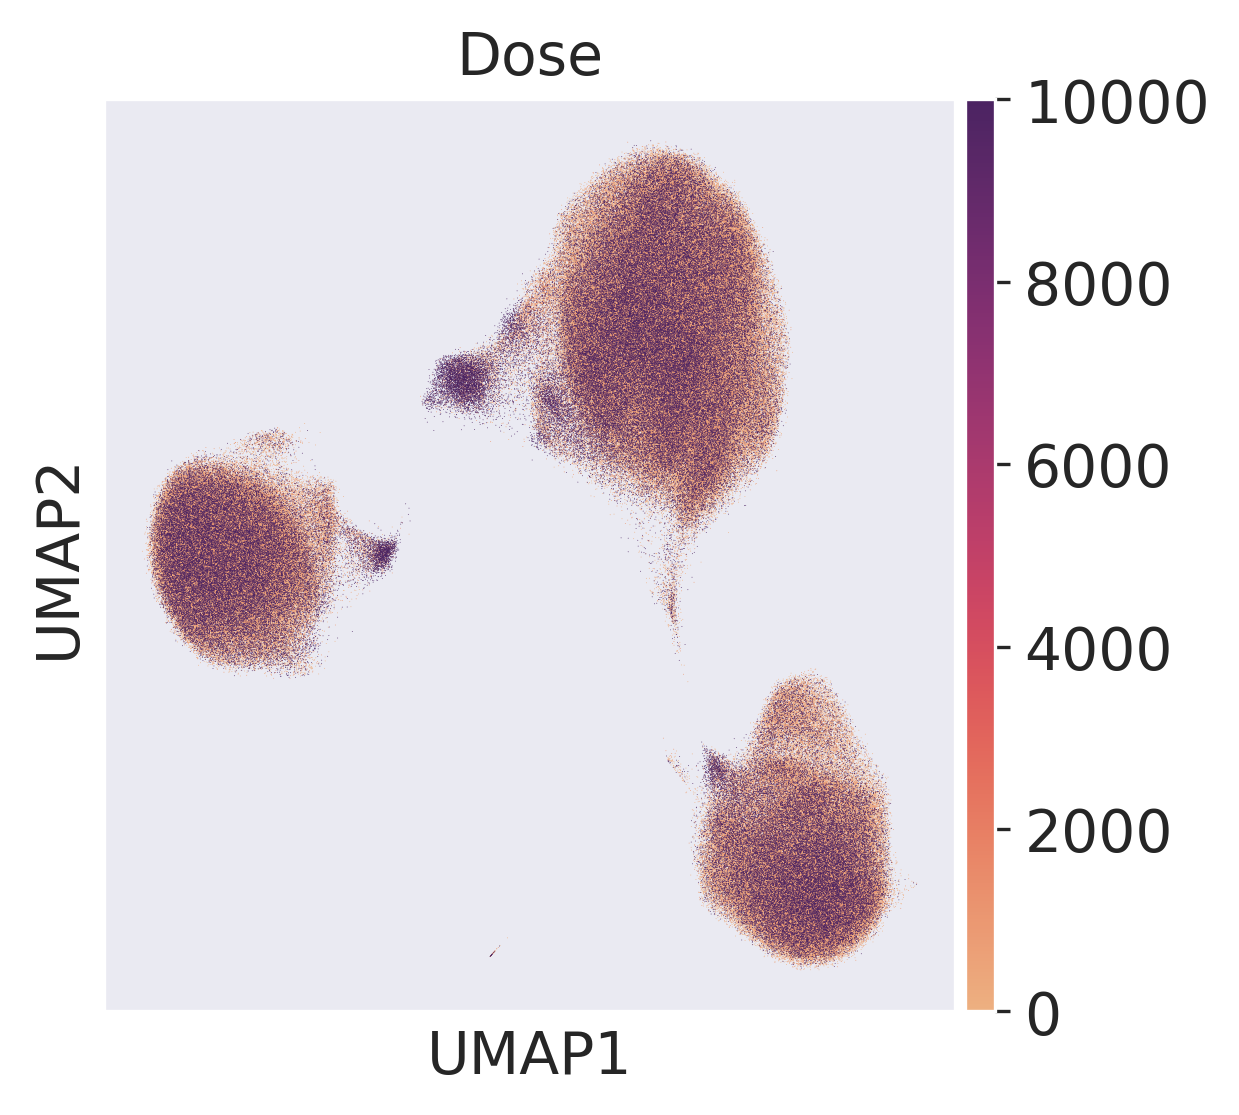

In [23]:
ax =sc.pl.umap(latent_adata, color = ["dose"], frameon=True, return_fig = True, cmap = "flare")
plt.title("Dose")

plt.savefig("../figures/S4A3.svg", bbox_inches='tight')

In [20]:
# def calculate_r2(
#     adata,
#     cell: str,
#     model: str,
#     condition_key: str,
#     axis_keys:dict,
#     diff_genes = None,
#     random_sample_coef = None,
#     n_iter: int = 1,
# ):
#     #Set condition key
    
#     #Densify sparse matrix
#     if sparse.issparse(adata.X):
#         adata.X = adata.X.A
    
#     #Treatment and Prediction
#     treat = adata[adata.obs[condition_key] == axis_keys["y"]] 
#     pred = adata[adata.obs[condition_key] == axis_keys["x"]]
    
#     r2_values_dict = {"R^2":[], "Gene Set":[]}
#     for i in range(n_iter):
        
#         if random_sample_coef is not None:
#             treat_idx = np.random.choice(np.arange(0, treat.shape[0]), int(random_sample_coef*treat.shape[0]))
#             pred_idx = np.random.choice(np.arange(0, pred.shape[0]), int(random_sample_coef*pred.shape[0]))
#             treat_samp = treat[treat_idx, :]
#             pred_samp = pred[pred_idx, :]
        
#         else:
#             treat_samp = treat
#             pred_samp = samp
            
#         if diff_genes is not None:
#             treat_diff = treat_samp[:, diff_genes]
#             pred_diff = pred_samp[:, diff_genes]

#             x_diff = np.average(pred_diff.X, axis=0)
#             y_diff = np.average(treat_diff.X, axis = 0)
#             m, b, r_value_diff, p_value_diff, std_err_diff = stats.linregress(
#                 x_diff, y_diff
#             )
#             r2_values_dict["R^2"].append(r_value_diff ** 2)
#             r2_values_dict["Gene Set"].append("DEGs")
            
    
#         x = np.average(treat_samp.X, axis = 0)
#         y = np.average(pred_samp.X, axis = 0)
#         m, b, r_value, p_value, std_err = stats.linregress(x, y)
#         r2_values_dict["R^2"].append(r_value ** 2)
#         r2_values_dict["Gene Set"].append("All HVGs")
        
#     r2_values_df = pd.DataFrame(r2_values_dict)
#     r2_values_df["Cell"] = cell
#     r2_values_df["Model"] = model
#     r2_values_df["Dose"] = axis_keys["y"]
#     return r2_values_df

In [21]:
# df_list = []
# regression = False
# cell = "A549"
# for idx, drug in enumerate(test_drugs):
#     print(idx)
#     print(drug)
#     model = VIDR(train_adata, linear_decoder = False)
# #     model.train(
# #     max_epochs=100,
# #     batch_size=128,
# #     early_stopping=True,
# #     early_stopping_patience=25)
    
# #     model.save(f"../../data/VAE_Binary_Prediction_Dioxin_5000g_{cell}.pt")
#     model = model.load(f"../../data/models/Continuous_VAE_sciplex3_80perDrug_24hours_DelA549.pt/", train_adata)
#     train_adata_drug = adata[adata.obs.product_name == drug]
#     model_name = "VAEArith"
    
#     max_dose = train_adata_drug.obs.dose.max()
#     min_dose = train_adata_drug.obs.dose.min()
#     doses = np.sort(train_adata_drug.obs.dose.unique())
    
#     ctrl_x = train_adata[train_adata.obs["product_name"] == "Vehicle", :]
#     treat_x = train_adata[(train_adata.obs["product_name"] == drug) & (train_adata.obs["dose"] == 10000)]
#     ctrl_x = random_sample(ctrl_x, "cell_type")
#     treat_x = random_sample(treat_x, "cell_type")
#     new_adata = ctrl_x.concatenate(treat_x)
#     new_adata = random_sample(new_adata, "dose", max_or_min = "min", replacement = False)
    
#     if sparse.issparse(new_adata.X):
#             new_adata.X = new_adata.X.A
    
#     ctrl_data = new_adata[(new_adata.obs["cell_type"] == "A549") & (new_adata.obs["product_name"] == "Vehicle")]
#     latent_cd = model.get_latent_representation(ctrl_data)
#     ctrl_x = new_adata[new_adata.obs["dose"] == 0].copy()
#     treat_x = new_adata[new_adata.obs["dose"] == 10000].copy()
    
#     #Compress data to latent space and then calculate the delta
#     latent_ctrl = np.average(model.get_latent_representation(ctrl_x), axis = 0)
#     latent_treat = np.average(model.get_latent_representation(treat_x), axis = 0)
#     delta = latent_treat - latent_ctrl
#     doses = adata.obs.dose.unique()
#     doses.sort()
#     treat_pred_dict = {d:delta*(np.log1p(d)/np.log1p(max(doses))) + latent_cd  for d in doses if d > min(doses)}
#     predicted_cells_dict = {d:model.module.generative(torch.Tensor(treat_pred_dict[d]))["px"].cpu().detach().numpy() for d in doses if d > min(doses)}
#     dr_dict = {d:sc.AnnData(X=predicted_cells_dict[d], obs=ctrl_data.obs.copy(), var=ctrl_data.var.copy(),obsm=ctrl_data.obsm.copy(),) for d in doses if d > min(doses)}
    
#     for key in dr_dict.keys():
#         dr_dict[key].obs["dose"] = f'{key} VAEArith'

#     ctrl_adata = adata[((adata.obs['cell_type'] == cell) & (adata.obs['dose'] == 0))]
#     eval_dict1 = {}

#     for d in doses[1:]:
#         stim_adata = adata[((adata.obs['cell_type'] == cell) & (adata.obs['dose'] == d))]
#         eval_dict1[d] = ctrl_adata.concatenate(stim_adata, dr_dict[d])
#         eval_dict1[d].obs["Dose"] = [str(i) if type(i) == float else i for i in eval_dict1[d].obs['dose']]

#     cell_adata = adata[(adata.obs["cell_type"] ==cell) & (adata.obs["product_name"] ==drug)]
#     cell_adata.obs["Dose"] = [str(i) for i in cell_adata.obs["dose"]]
#     sc.tl.rank_genes_groups(cell_adata, groupby="Dose", method="wilcoxon")
#     print("..Finished Differential Expression")
#     for d in doses[1:]:
#         print(d)
#         diff_genes = cell_adata.uns["rank_genes_groups"]["names"][str(d)]
#         print(eval_dict1[d].obs.Dose.unique())
#         r2_df = calculate_r2(
#             eval_dict1[d], 
#             cell,
#             model_name, 
#             "Dose", 
#             {"x":f'{d} VAEArith', "y":f"{d}"}, 
#             diff_genes=diff_genes[:100], 
#             random_sample_coef = 0.8,
#             n_iter = 100
#         )
#         r2_df.to_csv(f"../../data/Sciplex3_VAEArith_{d}_{drug}.csv")
#     print(f"...Finished {drug}")

0
TGX-221
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 298 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 888 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished TGX-221
1
Crizotinib (PF-02341066)
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 215 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 620 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Crizotinib (PF-02341066)
2
Tranylcypromine (2-PCPA) HCl
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 382 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 1120 cells, 5000 vars, 753        
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Tranylcypromine (2-PCPA) HCl
3
XAV-939
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 254 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 792 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished XAV-939
4
Decitabine
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 294 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 908 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Decitabine
5
Pirarubicin
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 148 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 466 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Pirarubicin
6
Temsirolimus (CCI-779, NSC 683864)
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 251 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 764 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Temsirolimus (CCI-779, NSC 683864)
7
SB431542
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 300 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 902 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished SB431542
8
Carmofur
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 291 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 854 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Carmofur
9
Belinostat (PXD101)
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 338 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 1020 cells, 5000 vars, 753        
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Belinostat (PXD101)
10
Anacardic Acid
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 303 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 974 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Anacardic Acid
11
AMG-900
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 254 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 824 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished AMG-900
12
Iniparib (BSI-201)
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 330 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 1012 cells, 5000 vars, 753        
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Iniparib (BSI-201)
13
Raltitrexed
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 251 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 734 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Raltitrexed
14
Ivosidenib (AG-120)
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 239 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 712 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Ivosidenib (AG-120)
15
Nintedanib (BIBF 1120)
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 131 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 434 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Nintedanib (BIBF 1120)
16
Nilotinib (AMN-107)
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 319 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 888 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Nilotinib (AMN-107)
17
Alendronate sodium trihydrate
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 211 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 646 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Alendronate sodium trihydrate
18
PD173074
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 263 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 742 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished PD173074
19
Barasertib (AZD1152-HQPA)
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 264 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 804 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Barasertib (AZD1152-HQPA)
20
Zileuton
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 303 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 960 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Zileuton
21
SL-327
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 234 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 738 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished SL-327
22
UNC0379
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 192 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 576 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished UNC0379
23
Tacedinaline (CI994)
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 380 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 1082 cells, 5000 vars, 753        
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Tacedinaline (CI994)
24
Glesatinib?(MGCD265)
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 219 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 606 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Glesatinib?(MGCD265)
25
Ofloxacin
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 393 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 1134 cells, 5000 vars, 753        
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Ofloxacin
26
Streptozotocin (STZ)
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 351 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 1016 cells, 5000 vars, 753        
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Streptozotocin (STZ)
27
Resminostat
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 295 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 900 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Resminostat
28
Resveratrol
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 387 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 1066 cells, 5000 vars, 753        
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Resveratrol
29
Belinostat (PXD101)
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 338 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 1020 cells, 5000 vars, 753        
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Belinostat (PXD101)
30
AG-490 (Tyrphostin B42)
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 341 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 1024 cells, 5000 vars, 753        
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished AG-490 (Tyrphostin B42)
31
UNC1999
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 340 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 1076 cells, 5000 vars, 753        
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished UNC1999
32
Trametinib (GSK1120212)
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 262 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 808 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Trametinib (GSK1120212)
33
ENMD-2076
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 177 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 540 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished ENMD-2076
34
Busulfan 
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 332 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 986 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Busulfan 
35
Trametinib (GSK1120212)
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 270 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 808 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished Trametinib (GSK1120212)
36
TMP195
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 310 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 936 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 VAEArith']
100.0
['0.0' '100.0' '100.0 VAEArith']
1000.0
['0.0' '1000.0' '1000.0 VAEArith']
10000.0
['0.0' '10000.0' '10000.0 VAEArith']
...Finished TMP195


In [22]:
# regression = True
# cell = "A549"
# for idx, drug in list(enumerate(test_drugs))[31:]:
#     print(drug, idx)
#     model = VIDR(train_adata.copy(), linear_decoder = False)
# #     model.train(
# #     max_epochs=100,
# #     batch_size=128,
# #     early_stopping=True,
# #     early_stopping_patience=25)
    
# #     model.save(f"../../data/VAE_Binary_Prediction_Dioxin_5000g_{cell}.pt")
#     model = model.load(f"../../data/models/Continuous_VAE_sciplex3_80perDrug_24hours_DelA549.pt/", train_adata)
#     train_adata_drug = adata[adata.obs.product_name == drug]
#     model_name = "scVIDR"
    
#     max_dose = train_adata_drug.obs.dose.max()
#     min_dose = train_adata_drug.obs.dose.min()
#     doses = np.sort(train_adata_drug.obs.dose.unique())
    
#     ctrl_x = train_adata[train_adata.obs["product_name"] == "Vehicle", :]
#     treat_x = train_adata[(train_adata.obs["product_name"] == drug) & (train_adata.obs["dose"] == max_dose)]
#     ctrl_x = random_sample(ctrl_x, "cell_type")
#     treat_x = random_sample(treat_x, "cell_type")
#     new_adata = ctrl_x.concatenate(treat_x)
#     new_adata = random_sample(new_adata, "dose", max_or_min = "min", replacement = False)
#     if sparse.issparse(new_adata.X):
#             new_adata.X = new_adata.X.A
#     ctrl_data = new_adata[(new_adata.obs["cell_type"] == "A549") & (new_adata.obs["product_name"] == "Vehicle")]
#     latent_cd = model.get_latent_representation(ctrl_data)
#     #Regression on latent space
#     latent_X =  model.get_latent_representation(new_adata)
#     latent_adata = sc.AnnData(X=latent_X, obs = new_adata.obs.copy())
#     #Get deltas and control centroids for each cell tpye in the training dataset
#     deltas = []
#     latent_centroids = []
#     cell_types = np.unique(latent_adata.obs["cell_type"])
#     for cell_type in cell_types:
#         if cell_type != "A549":
#             latent_ctrl = latent_adata[(latent_adata.obs["cell_type"] == cell_type) & (latent_adata.obs["dose"] == 0)]
#             latent_treat = latent_adata[(latent_adata.obs["cell_type"] == cell_type) & (latent_adata.obs["dose"] == 10000)]
#             ctrl_centroid = np.average(latent_ctrl.X, axis = 0)
#             treat_centroid = np.average(latent_treat.X, axis = 0)
#             delta = np.average(latent_treat.X, axis = 0) - np.average(latent_ctrl.X, axis = 0)
#             deltas.append(delta)
#             latent_centroids.append(ctrl_centroid)
#     lr = LinearRegression()
#     reg = lr.fit(latent_centroids, deltas)
#     delta = reg.predict([np.average(latent_cd, axis = 0)])[0]
#     doses = adata.obs.dose.unique()
#     doses.sort()
#     treat_pred_dict = {d:delta*(np.log1p(d)/np.log1p(max(doses))) + latent_cd  for d in doses if d > min(doses)}
#     predicted_cells_dict = {d:model.module.generative(torch.Tensor(treat_pred_dict[d]))["px"].cpu().detach().numpy() for d in doses if d > min(doses)}
#     dr_dict = {d:sc.AnnData(X=predicted_cells_dict[d], obs=ctrl_data.obs.copy(), var=ctrl_data.var.copy(),obsm=ctrl_data.obsm.copy(),) for d in doses if d > min(doses)}
#     for key in dr_dict.keys():
#         dr_dict[key].obs["dose"] = f'{key} scVIDR'

#     ctrl_adata = adata[((adata.obs['cell_type'] == cell) & (adata.obs['dose'] == 0))]
#     eval_dict1 = {}

#     for d in doses[1:]:
#         stim_adata = adata[((adata.obs['cell_type'] == cell) & (adata.obs['dose'] == d))]
#         eval_dict1[d] = ctrl_adata.concatenate(stim_adata, dr_dict[d])
#         eval_dict1[d].obs["Dose"] = [str(i) if type(i) == float else i for i in eval_dict1[d].obs['dose']]

#     cell_adata = adata[(adata.obs["cell_type"] ==cell) & (adata.obs["product_name"] ==drug)]
#     cell_adata.obs["Dose"] = [str(i) for i in cell_adata.obs["dose"]]
#     sc.tl.rank_genes_groups(cell_adata, groupby="Dose", method="wilcoxon")
#     print("..Finished Differential Expression")
#     for d in doses[1:]:
#         print(d)
#         diff_genes = cell_adata.uns["rank_genes_groups"]["names"][str(d)]
#         print(eval_dict1[d].obs.Dose.unique())
#         r2_df = calculate_r2(
#             eval_dict1[d], 
#             cell,
#             model_name, 
#             "Dose", 
#             {"x":f'{d} scVIDR', "y":f"{d}"}, 
#             diff_genes=diff_genes[:100], 
#             random_sample_coef = 0.8,
#             n_iter = 100
#         )
#         r2_df.to_csv(f"../../data/Sciplex3_scVIDR_{d}_{drug}.csv")
#     print(f"...Finished {drug}")

UNC1999 31
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 381 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 scVIDR']
100.0
['0.0' '100.0' '100.0 scVIDR']
1000.0
['0.0' '1000.0' '1000.0 scVIDR']
10000.0
['0.0' '10000.0' '10000.0 scVIDR']
...Finished {drug}
Trametinib (GSK1120212) 32
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 263 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 scVIDR']
100.0
['0.0' '100.0' '100.0 scVIDR']
1000.0
['0.0' '1000.0' '1000.0 scVIDR']
10000.0
['0.0' '10000.0' '10000.0 scVIDR']
...Finished {drug}
ENMD-2076 33
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 190 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 scVIDR']
100.0
['0.0' '100.0' '100.0 scVIDR']
1000.0
['0.0' '1000.0' '1000.0 scVIDR']
10000.0
['0.0' '10000.0' '10000.0 scVIDR']
...Finished {drug}
Busulfan  34
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 306 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 scVIDR']
100.0
['0.0' '100.0' '100.0 scVIDR']
1000.0
['0.0' '1000.0' '1000.0 scVIDR']
10000.0
['0.0' '10000.0' '10000.0 scVIDR']
...Finished {drug}
Trametinib (GSK1120212) 35
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 273 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 scVIDR']
100.0
['0.0' '100.0' '100.0 scVIDR']
1000.0
['0.0' '1000.0' '1000.0 scVIDR']
10000.0
['0.0' '10000.0' '10000.0 scVIDR']
...Finished {drug}
TMP195 36
None
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 651019 cells, 5000 vars, 753      
         batches, 3 labels, and 0 proteins. Also registered 0 extra categorical covariates   
         and 0 extra continuous covariates.                                                  
None


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Received view of anndata, making copy.                                              


Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mean', 'local_l_var', 'labels']     
INFO     Successfully registered anndata object containing 336 cells, 5000 vars, 753 batches,
         3 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Input adata not setup with scvi. attempting to transfer anndata setup               
INFO     Using data from adata.X                                                             
INFO     Computing library size prior per batch                                              
INFO     Registered keys:['X', 'batch_indices', 'local_l_mea

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

..Finished Differential Expression
10.0
['0.0' '10.0' '10.0 scVIDR']
100.0
['0.0' '100.0' '100.0 scVIDR']
1000.0
['0.0' '1000.0' '1000.0 scVIDR']
10000.0
['0.0' '10000.0' '10000.0 scVIDR']
...Finished {drug}


In [25]:
df_list = []
doses = [0.0, 10.0, 100.0, 1000.0, 10000.0]
for idx, drug in enumerate(test_drugs):
    for d in doses[1:]:
        df = pd.read_csv(f"../data/Sciplex3_VAEArith_{d}_{drug}.csv")
        df["drug"] = drug
        df_list.append(df)
for idx, drug in enumerate(test_drugs):
    for d in doses[1:]:
        df = pd.read_csv(f"../data/Sciplex3_scVIDR_{d}_{drug}.csv")
        df["drug"] = drug
        df_list.append(df)

In [26]:
df_full = pd.concat(df_list)

In [27]:
df_full["Dose"] = df_full["Dose"].astype(str)

In [28]:
pathway_dict = {drug:pathway for drug, pathway in zip(adata.obs["product_name"], adata.obs["pathway"])}

In [29]:
df_full["pathway"] = df_full["drug"].apply(pathway_dict.get)

In [30]:
df_hvg = df_full[df_full["Gene Set"] == "All HVGs"]

In [31]:
pathways = sorted(df_hvg.pathway.unique())

In [32]:
Counter(df_hvg.pathway)

Counter({'PI3K/Akt/mTOR': 1600,
         'Protein Tyrosine Kinase': 3200,
         'Epigenetics': 8800,
         'Stem Cells &  Wnt': 800,
         'DNA Damage': 5600,
         'TGF-beta/Smad': 800,
         'Cell Cycle': 1600,
         'Metabolism': 1600,
         'Angiogenesis': 2400,
         'Others': 800,
         'MAPK': 2400})

## Supplemental Figure 4D1

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

100.0_scVIDR vs. 100.0_VAEArith: Mann-Whitney-Wilcoxon test greater, P_val:0.000e+00 U_stat=1.058e+07
10.0_scVIDR vs. 10.0_VAEArith: Mann-Whitney-Wilcoxon test greater, P_val:2.404e-165 U_stat=9.361e+06
1000.0_scVIDR vs. 1000.0_VAEArith: Mann-Whitney-Wilcoxon test greater, P_val:0.000e+00 U_stat=1.176e+07
10000.0_scVIDR vs. 10000.0_VAEArith: Mann-Whitney-Wilcoxon test greater, P_val:0.000e+00 U_stat=1.206e+07


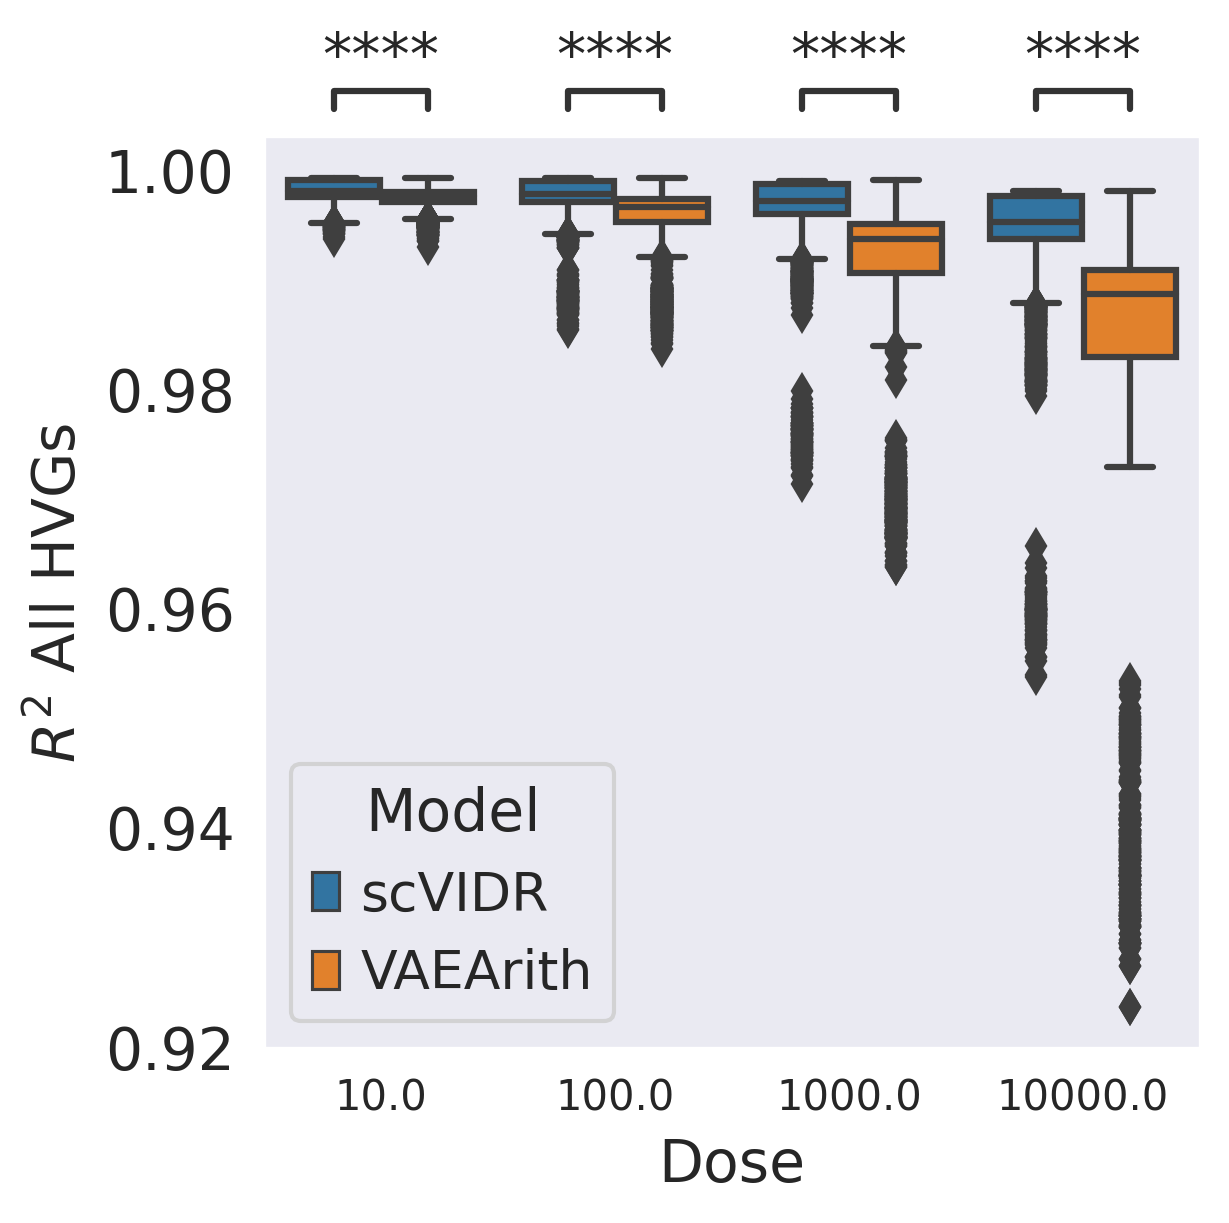

In [34]:
order = [str(i) for i in doses][1:]
hue_order = ['scVIDR', 'VAEArith']
ax = sns.boxplot(x = "Dose", y = "R^2",  data = df_hvg, hue = "Model", order = order, hue_order = hue_order)
pairs = [
    (("10.0", "scVIDR"),("10.0", "VAEArith")),
    (("100.0", "scVIDR"),("100.0", "VAEArith")),
    (("1000.0", "scVIDR"),("1000.0", "VAEArith")),
    (("10000.0", "scVIDR"),("10000.0", "VAEArith")),
]
annotator = Annotator(ax, pairs, data=df_hvg, x="Dose", y="R^2", hue = "Model", order = order, hue_order=hue_order)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside')
annotator.apply_and_annotate()
plt.xticks(fontsize = 10)
plt.ylabel(r"$R^2$ All HVGs")
plt.savefig("../figures/SF4D1.svg")
plt.show()

In [35]:
df_deg = df_full[df_full["Gene Set"] == "DEGs"]

# Supplemental Figure 4C

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

100.0_scVIDR vs. 100.0_VAEArith: Mann-Whitney-Wilcoxon test greater, P_val:2.409e-67 U_stat=4.000e+04
10.0_scVIDR vs. 10.0_VAEArith: Mann-Whitney-Wilcoxon test greater, P_val:2.409e-67 U_stat=4.000e+04
1000.0_scVIDR vs. 1000.0_VAEArith: Mann-Whitney-Wilcoxon test greater, P_val:2.409e-67 U_stat=4.000e+04
10000.0_scVIDR vs. 10000.0_VAEArith: Mann-Whitney-Wilcoxon test greater, P_val:2.409e-67 U_stat=4.000e+04


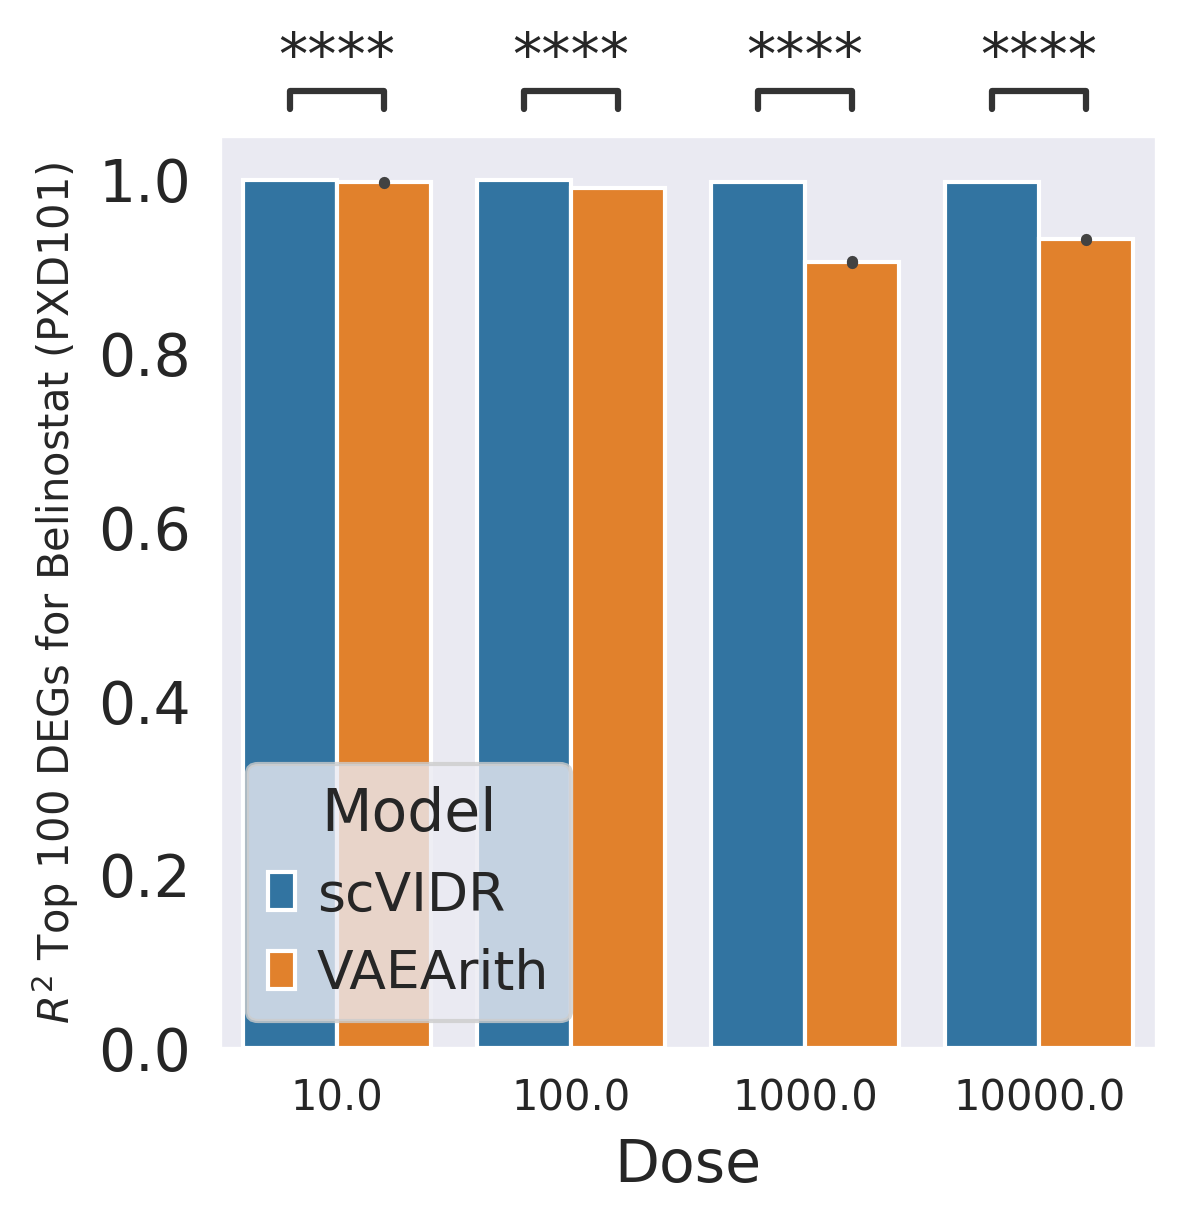

In [39]:
drug = "Belinostat (PXD101)"
df = df_deg[df_deg.drug == drug]
order = [str(i) for i in doses][1:]
hue_order = ["scVIDR", "VAEArith"]
ax = sns.barplot(x = "Dose", y = "R^2",  data = df, hue = "Model", order = order, hue_order = hue_order)
pairs = [
    (("10.0", "scVIDR"),("10.0", "VAEArith")),
    (("100.0", "scVIDR"),("100.0", "VAEArith")),
    (("1000.0", "scVIDR"),("1000.0", "VAEArith")),
    (("10000.0", "scVIDR"),("10000.0", "VAEArith")),
]
annotator = Annotator(ax, pairs, data=df, x="Dose", y="R^2", hue = "Model", order = order, hue_order=hue_order)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside')
annotator.apply_and_annotate()
plt.xticks(fontsize = 10)
plt.ylabel(f"$R^2$ Top 100 DEGs for {drug}", fontsize = 10)
plt.savefig(f'../figures/SF4C_{drug.replace("/", "_")}.svg')
plt.show()

# Supplementary Figure 4D2

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

100.0_scVIDR vs. 100.0_VAEArith: Mann-Whitney-Wilcoxon test greater, P_val:1.435e-90 U_stat=8.696e+06
10.0_scVIDR vs. 10.0_VAEArith: Mann-Whitney-Wilcoxon test greater, P_val:4.757e-51 U_stat=8.222e+06
1000.0_scVIDR vs. 1000.0_VAEArith: Mann-Whitney-Wilcoxon test greater, P_val:1.602e-245 U_stat=9.918e+06
10000.0_scVIDR vs. 10000.0_VAEArith: Mann-Whitney-Wilcoxon test greater, P_val:9.229e-265 U_stat=1.004e+07


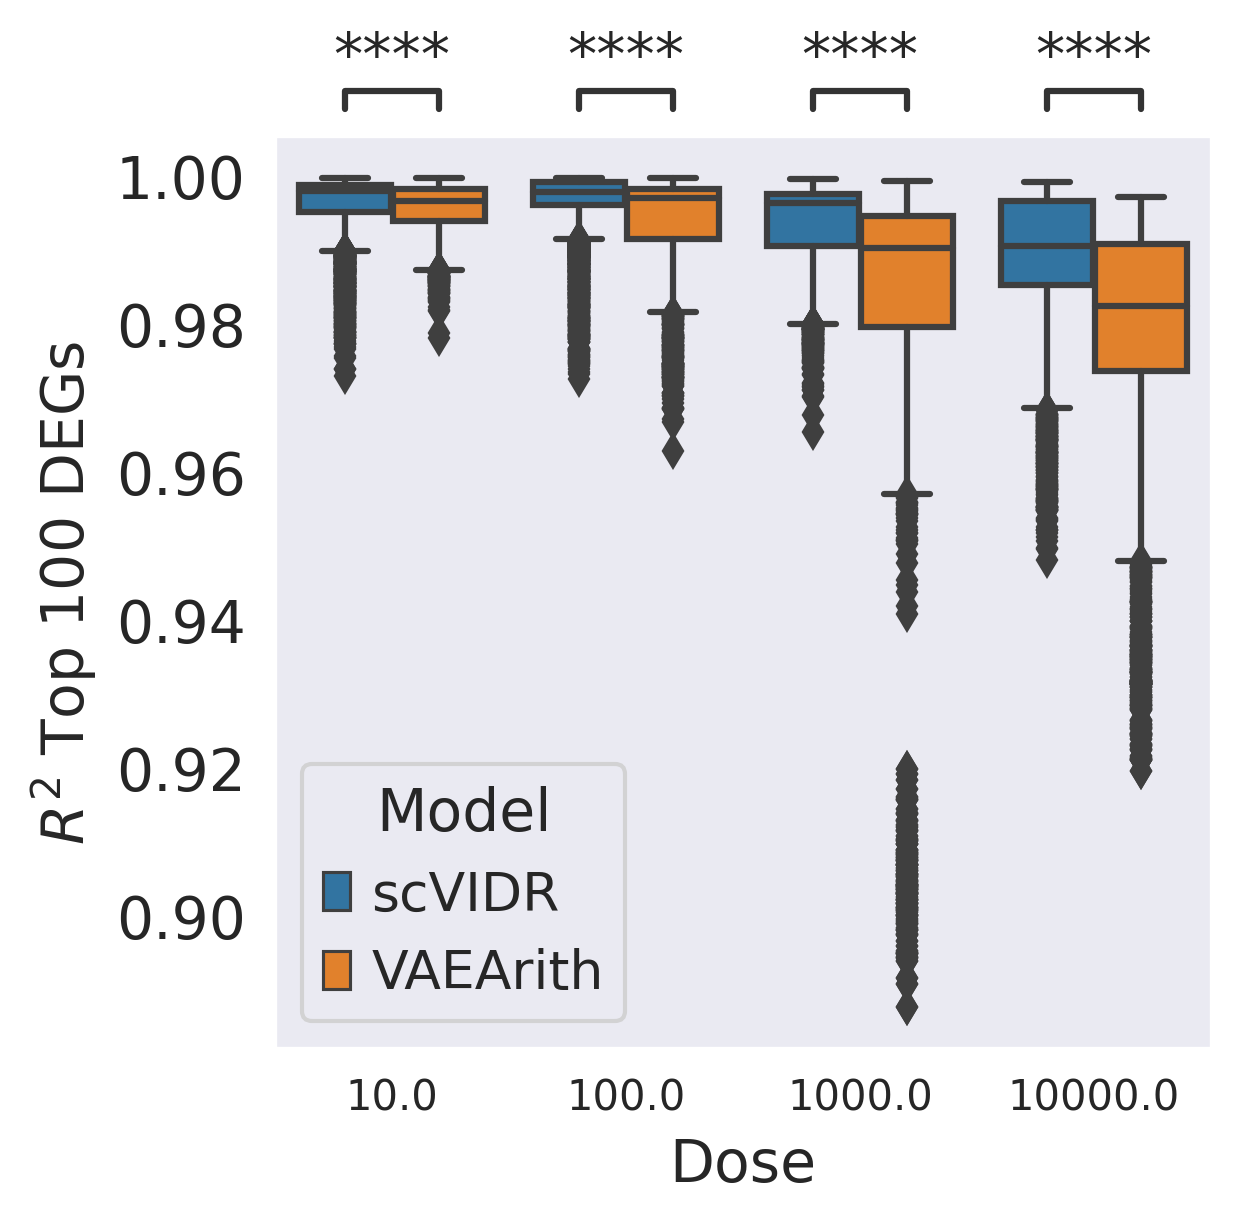

In [40]:
order = [str(i) for i in doses][1:]
hue_order = ['scVIDR', 'VAEArith']
ax = sns.boxplot(x = "Dose", y = "R^2",  data = df_deg, hue = "Model", order = order, hue_order = hue_order)
pairs = [
    (("10.0", "scVIDR"),("10.0", "VAEArith")),
    (("100.0", "scVIDR"),("100.0", "VAEArith")),
    (("1000.0", "scVIDR"),("1000.0", "VAEArith")),
    (("10000.0", "scVIDR"),("10000.0", "VAEArith")),
]
annotator = Annotator(ax, pairs, data=df_deg, x="Dose", y="R^2", hue = "Model", order = order, hue_order=hue_order)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside')
annotator.apply_and_annotate()
plt.xticks(fontsize = 10)
plt.ylabel(r"$R^2$ Top 100 DEGs")
plt.savefig("../figures/SF4D2.svg")
plt.show()

In [42]:
df_list = []
regression = True
cell = "A549"
drug = "Belinostat (PXD101)"
model = VIDR(train_adata, linear_decoder = False)
#     model.train(
#     max_epochs=100,
#     batch_size=128,
#     early_stopping=True,
#     early_stopping_patience=25)

#     model.save(f"../../data/VAE_Binary_Prediction_Dioxin_5000g_{cell}.pt")
model = model.load(f"../data/models/Continuous_VAE_sciplex3_80perDrug_24hours_DelA549.pt/", train_adata)
train_adata_drug = adata[adata.obs.product_name == drug]
model_name = "scVIDR"

max_dose = train_adata_drug.obs.dose.max()
min_dose = train_adata_drug.obs.dose.min()
doses = np.sort(train_adata_drug.obs.dose.unique())

ctrl_x = train_adata[train_adata.obs["product_name"] == "Vehicle", :]
treat_x = train_adata[(train_adata.obs["product_name"] == drug) & (train_adata.obs["dose"] == 10000)]
ctrl_x = random_sample(ctrl_x, "cell_type")
treat_x = random_sample(treat_x, "cell_type")
new_adata = ctrl_x.concatenate(treat_x)
new_adata = random_sample(new_adata, "dose", max_or_min = "min", replacement = False)

if sparse.issparse(new_adata.X):
        new_adata.X = new_adata.X.A

ctrl_data = new_adata[(new_adata.obs["cell_type"] == "A549") & (new_adata.obs["product_name"] == "Vehicle")]
latent_cd = model.get_latent_representation(ctrl_data)
ctrl_x = new_adata[new_adata.obs["dose"] == 0].copy()
treat_x = new_adata[new_adata.obs["dose"] == 10000].copy()

#Get deltas and control centroids for each cell tpye in the training dataset
deltas = []
latent_centroids = []
cell_types = np.unique(latent_adata.obs["cell_type"])
for cell_type in cell_types:
    if cell_type != "A549":
        latent_ctrl = latent_adata[(latent_adata.obs["cell_type"] == cell_type) & (latent_adata.obs["dose"] == 0)]
        latent_treat = latent_adata[(latent_adata.obs["cell_type"] == cell_type) & (latent_adata.obs["dose"] == 10000)]
        ctrl_centroid = np.average(latent_ctrl.X, axis = 0)
        treat_centroid = np.average(latent_treat.X, axis = 0)
        delta = np.average(latent_treat.X, axis = 0) - np.average(latent_ctrl.X, axis = 0)
        deltas.append(delta)
        latent_centroids.append(ctrl_centroid)
lr = LinearRegression()
reg = lr.fit(latent_centroids, deltas)
delta = reg.predict([np.average(latent_cd, axis = 0)])[0]
doses = adata.obs.dose.unique()
doses.sort()
treat_pred_dict = {d:delta*(np.log1p(d)/np.log1p(max(doses))) + latent_cd  for d in doses if d > min(doses)}
predicted_cells_dict = {d:model.module.generative(torch.Tensor(treat_pred_dict[d]))["px"].cpu().detach().numpy() for d in doses if d > min(doses)}
dr_dict = {d:sc.AnnData(X=predicted_cells_dict[d], obs=ctrl_data.obs.copy(), var=ctrl_data.var.copy(),obsm=ctrl_data.obsm.copy(),) for d in doses if d > min(doses)}
for key in dr_dict.keys():
    dr_dict[key].obs["dose"] = f'{key} scVIDR'

ctrl_adata = adata[((adata.obs['cell_type'] == cell) & (adata.obs['dose'] == 0))]
eval_dict1 = {}

for d in doses[1:]:
    stim_adata = adata[((adata.obs['cell_type'] == cell) & (adata.obs['dose'] == d))]
    eval_dict1[d] = ctrl_adata.concatenate(stim_adata, dr_dict[d])
    eval_dict1[d].obs["Dose"] = [str(i) if type(i) == float else i for i in eval_dict1[d].obs['dose']]

cell_adata = adata[(adata.obs["cell_type"] ==cell) & (adata.obs["product_name"] ==drug)]
cell_adata.obs["Dose"] = [str(i) for i in cell_adata.obs["dose"]]

None


OSError: ../data/models/Continuous_VAE_sciplex3_80perDrug_24hours_DelA549.pt/var_names.csv not found.

In [43]:
df_list = []
regression = False
cell = "A549"
drug = "Belinostat (PXD101)"
model = VIDR(train_adata, linear_decoder = False)
#     model.train(
#     max_epochs=100,
#     batch_size=128,
#     early_stopping=True,
#     early_stopping_patience=25)

#     model.save(f"../../data/VAE_Binary_Prediction_Dioxin_5000g_{cell}.pt")
model = model.load(f"../data/models/Continuous_VAE_sciplex3_80perDrug_24hours_DelA549.pt/", train_adata)
train_adata_drug = adata[adata.obs.product_name == drug]
model_name = "VAEArith"

max_dose = train_adata_drug.obs.dose.max()
min_dose = train_adata_drug.obs.dose.min()
doses = np.sort(train_adata_drug.obs.dose.unique())

ctrl_x = train_adata[train_adata.obs["product_name"] == "Vehicle", :]
treat_x = train_adata[(train_adata.obs["product_name"] == drug) & (train_adata.obs["dose"] == 10000)]
ctrl_x = random_sample(ctrl_x, "cell_type")
treat_x = random_sample(treat_x, "cell_type")
new_adata = ctrl_x.concatenate(treat_x)
new_adata = random_sample(new_adata, "dose", max_or_min = "min", replacement = False)

if sparse.issparse(new_adata.X):
        new_adata.X = new_adata.X.A

ctrl_data = new_adata[(new_adata.obs["cell_type"] == "A549") & (new_adata.obs["product_name"] == "Vehicle")]
latent_cd = model.get_latent_representation(ctrl_data)
ctrl_x = new_adata[new_adata.obs["dose"] == 0].copy()
treat_x = new_adata[new_adata.obs["dose"] == 10000].copy()

#Compress data to latent space and then calculate the delta
latent_ctrl = np.average(model.get_latent_representation(ctrl_x), axis = 0)
latent_treat = np.average(model.get_latent_representation(treat_x), axis = 0)
delta = latent_treat - latent_ctrl
doses = adata.obs.dose.unique()
doses.sort()

None


OSError: ../data/models/Continuous_VAE_sciplex3_80perDrug_24hours_DelA549.pt/var_names.csv not found.

In [76]:
treat_pred_dict = {d:delta*(np.log1p(d)/np.log1p(max(doses))) + latent_cd  for d in doses if d > min(doses)}
predicted_cells_dict = {d:model.module.generative(torch.Tensor(treat_pred_dict[d]))["px"].cpu().detach().numpy() for d in doses if d > min(doses)}
dr_dict = {d:sc.AnnData(X=predicted_cells_dict[d], obs=ctrl_data.obs.copy(), var=ctrl_data.var.copy(),obsm=ctrl_data.obsm.copy(),) for d in doses if d > min(doses)}

for key in dr_dict.keys():
    dr_dict[key].obs["dose"] = f'{key} VAEArith'

ctrl_adata = adata[((adata.obs['cell_type'] == cell) & (adata.obs['dose'] == 0))]
eval_dict2 = {}

for d in doses[1:]:
    stim_adata = adata[((adata.obs['cell_type'] == cell) & (adata.obs['dose'] == d))]
    eval_dict2[d] = ctrl_adata.concatenate(stim_adata, dr_dict[d])
    eval_dict2[d].obs["Dose"] = [str(i) if type(i) == float else i for i in eval_dict2[d].obs['dose']]

cell_adata = adata[(adata.obs["cell_type"] ==cell) & (adata.obs["product_name"] ==drug)]
cell_adata.obs["Dose"] = [str(i) for i in cell_adata.obs["dose"]]

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

In [77]:
eval_dict = {d:eval_dict1[d].concatenate(eval_dict2[d][["VAEArith" in i for i in eval_dict2[d].obs["Dose"]]]) for d in doses[1:]}

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique,

In [78]:
eval_adata = eval_dict[10].concatenate([eval_dict[d] for d in doses[2:]])

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [79]:
bool_array = ((adata.obs["cell_type"] ==cell) & (adata.obs["product_name"] ==drug)) | ((adata.obs["cell_type"] ==cell) & (adata.obs["product_name"] =="Vehicle"))
cell_adata = adata[bool_array]
cell_adata = cell_adata[(cell_adata.obs.dose == 0) |  (cell_adata.obs.dose == 10000)]
cell_adata.obs["Dose"] = [str(i) for i in cell_adata.obs["dose"]]

Trying to set attribute `.obs` of view, copying.


In [84]:
response = []
for i in eval_adata.obs.Dose:
    if "scVIDR" in i:
        response.append("scVIDR")
    elif "VAEArith" in i:
        response.append("VAEArith")
    else:
        response.append("Real Expression")
eval_adata.obs["Response"] = response

In [85]:
gene = "MALAT1"
df = eval_adata.obs[["Dose", "Response"]]
eval_adata.var.index = eval_adata.var["gene_short_name"]
df[gene] = eval_adata[:, gene].X.A.squeeze()
df["Dose"] = [float(i.split(" ")[0]) if type(i) == str else i for i in df["Dose"]]
df["Log Dose"] = [np.log1p(i) for i in df["Dose"]]

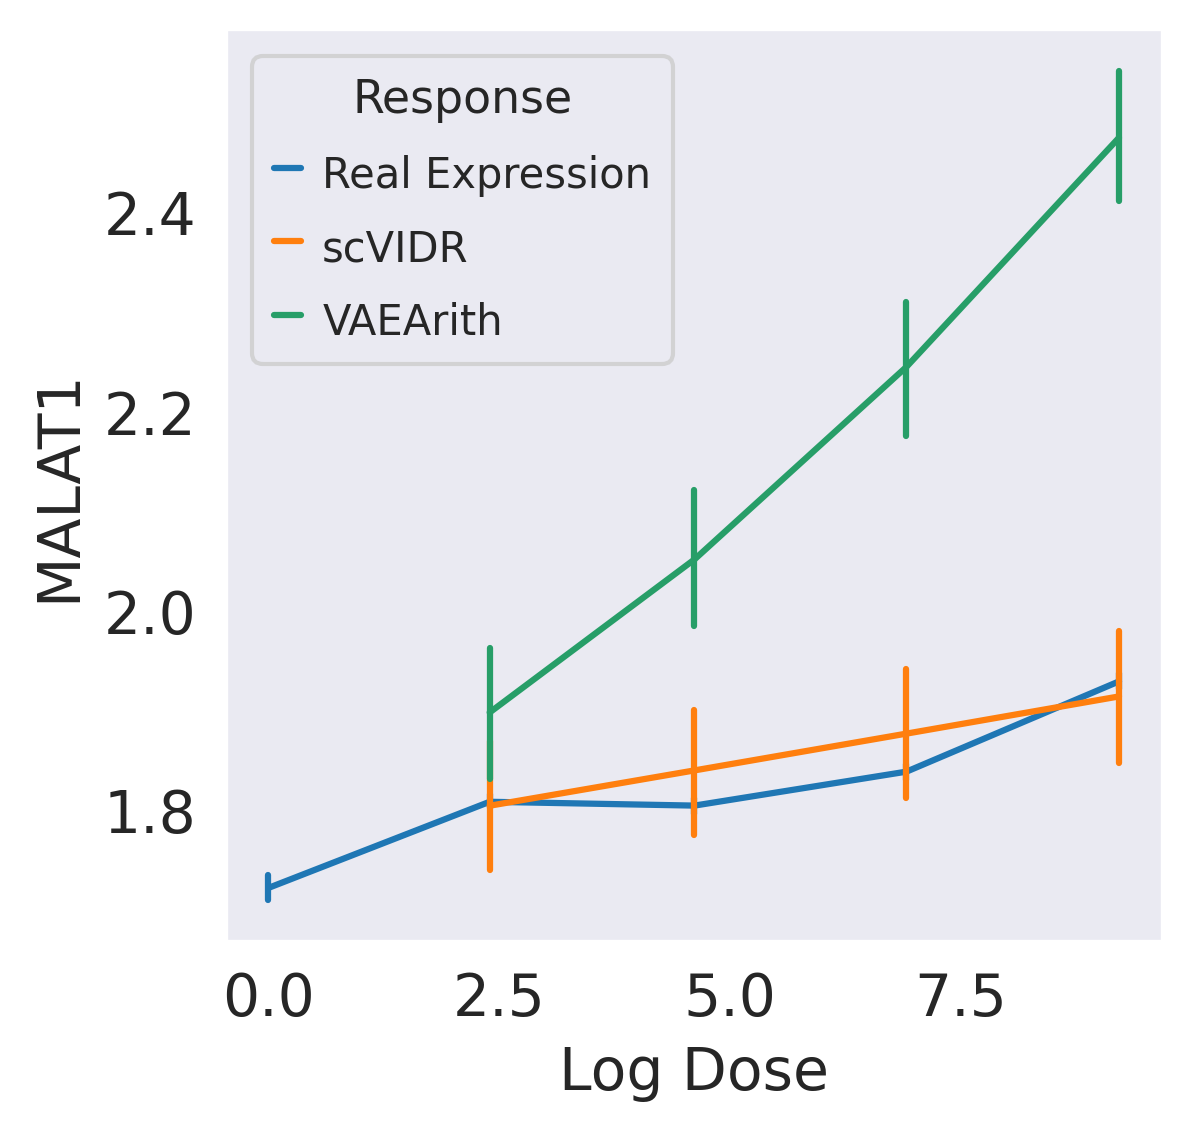

In [86]:
ax = sns.lineplot(x = "Log Dose", y = gene, hue = "Response", data = df, err_style="bars")
plt.setp(ax.get_legend().get_texts(), fontsize='10') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='11') # for legend title
plt.savefig("../Figures/SF4C.svg")
plt.show()

In [88]:
#For calculating statistical distance
import geomloss
import pykeops
import pykeops
pykeops.clean_pykeops()          # just in case old build files are still present
pykeops.test_numpy_bindings()    # perform the compilation

[KeOps] /mnt/home/kanaomar/.cache/keops2.0/build_CUDA_VISIBLE_DEVICES_0_1_2_3 has been cleaned.
[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK
[KeOps] Generating code for formula Sum_Reduction((Var(0,3,0)-Var(1,3,1))|(Var(0,3,0)-Var(1,3,1)),1) ... OK
pyKeOps with numpy bindings is working!


In [89]:
df_dict = {"Model":[], "Log Dose":[], "Sinkhorn Distance":[]}
mmd = geomloss.SamplesLoss("sinkhorn")
log_dose = df["Log Dose"].unique()
for dose in log_dose[1:]:
    df_dose = df[df["Log Dose"] == dose]
    real_ahrr = df_dose[df_dose.Response == "Real Expression"][gene].values
    scVIDR_ahrr = df_dose[df_dose.Response == "scVIDR"][gene].values
    VAEArith_ahrr = df_dose[df_dose.Response == "VAEArith"][gene].values
    real_tensor = torch.Tensor([real_ahrr]).T
    scVIDR_tensor = torch.Tensor([scVIDR_ahrr]).T
    VAEArith_tensor = torch.Tensor([VAEArith_ahrr]).T
    stat_dist = mmd(real_tensor, scVIDR_tensor).numpy().tolist()
    df_dict["Log Dose"].append(f'{dose:.{3}f}')
    df_dict["Model"].append("scVIDR")
    df_dict["Sinkhorn Distance"].append(stat_dist)
    print(f"scVIDR {dose}: {stat_dist}")
    
    stat_dist = mmd(real_tensor, VAEArith_tensor).numpy().tolist()
    df_dict["Log Dose"].append(f'{dose:.{3}f}')
    df_dict["Model"].append("VAEArith")
    df_dict["Sinkhorn Distance"].append(stat_dist)
    print(f"VAEArith {dose}: {stat_dist}")

scVIDR 2.3978952727983707: 0.010838132351636887
VAEArith 2.3978952727983707: 0.017037928104400635
scVIDR 4.61512051684126: 0.01228361390531063
VAEArith 4.61512051684126: 0.043471559882164
scVIDR 6.90875477931522: 0.01594771258533001
VAEArith 6.90875477931522: 0.09712056070566177
scVIDR 9.210440366976517: 0.019401179626584053
VAEArith 9.210440366976517: 0.16627751290798187


In [90]:
from matplotlib import cm

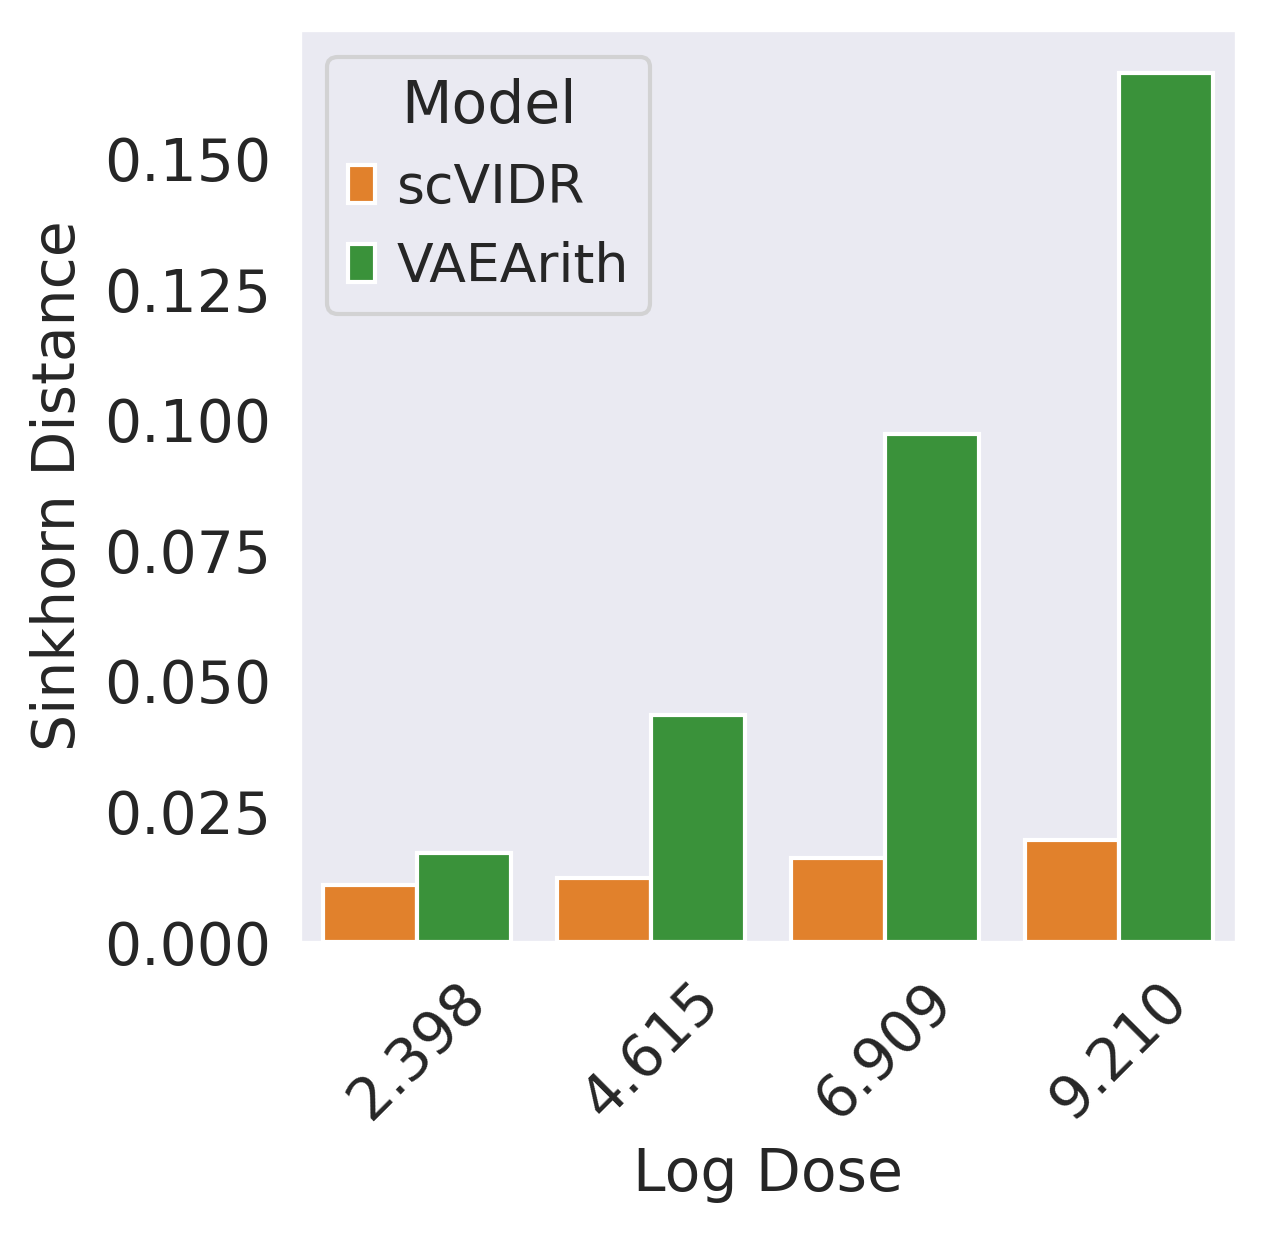

In [91]:
df_dists = pd.DataFrame(df_dict)
sns.barplot(x = "Log Dose", y = "Sinkhorn Distance", hue = "Model", data = df_dists, palette=cm.tab10.colors[1:])
plt.xticks(rotation = 45)
plt.show()